Data reading 

In [ ]:
# ================================
# CUSTOMER CHURN PREDICTION
# ================================

# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
import pickle 
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')

In [33]:
# ================================
# STEP 1: LOAD DATA
# ================================
train_df = pd.read_csv('/home/parasuram/Tango/EDGE/archive/customer_churn_dataset-training-master.csv')
test_df = pd.read_csv('/home/parasuram/Tango/EDGE/archive/customer_churn_dataset-testing-master.csv')

print("✅ Train Shape:", train_df.shape)
print("✅ Test Shape:", test_df.shape)

# Display sample
print("\n--- Sample Train Data ---")
print(train_df.head(3))

✅ Train Shape: (440833, 12)
✅ Test Shape: (64374, 12)

--- Sample Train Data ---
   CustomerID   Age  Gender  Tenure  Usage Frequency  Support Calls  \
0         2.0  30.0  Female    39.0             14.0            5.0   
1         3.0  65.0  Female    49.0              1.0           10.0   
2         4.0  55.0  Female    14.0              4.0            6.0   

   Payment Delay Subscription Type Contract Length  Total Spend  \
0           18.0          Standard          Annual        932.0   
1            8.0             Basic         Monthly        557.0   
2           18.0             Basic       Quarterly        185.0   

   Last Interaction  Churn  
0              17.0    1.0  
1               6.0    1.0  
2               3.0    1.0  


In [34]:
# ================================
# STEP 2: BASIC DATA INSPECTION
# ================================
print("\n--- Train Info ---")
print(train_df.info())

print("\n--- Missing Values (Train) ---")
print(train_df.isnull().sum())

print("\n--- Missing Values (Test) ---")
print(test_df.isnull().sum())

# Drop rows with missing values (optional: you can impute instead)
train_df = train_df.dropna()
test_df = test_df.dropna()

print(f"\n✅ After dropping NA: Train = {train_df.shape}, Test = {test_df.shape}")


--- Train Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB
None

--- Missing Values (Train) ---
CustomerID           1
Age                  1
Gender               1
Tenure               1
U

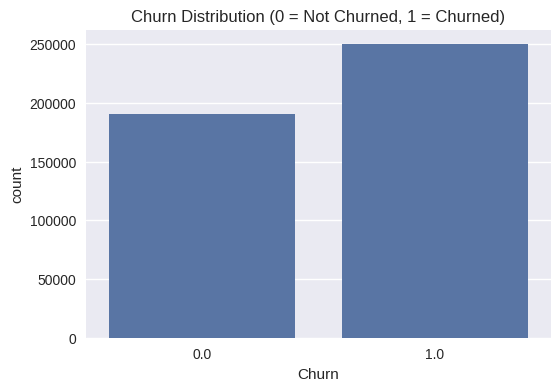


--- Churn Ratio ---
Churn
1.0    0.567107
0.0    0.432893
Name: proportion, dtype: float64


In [35]:
# ================================
# STEP 3: EDA — TARGET DISTRIBUTION
# ================================
plt.figure(figsize=(6,4))
sns.countplot(data=train_df, x='Churn')
plt.title('Churn Distribution (0 = Not Churned, 1 = Churned)')
plt.show()

churn_ratio = train_df['Churn'].value_counts(normalize=True)
print("\n--- Churn Ratio ---")
print(churn_ratio)

In [36]:
# ================================
# STEP 4: ENCODE CATEGORICAL VARIABLES
# ================================
categorical_cols = ['Gender', 'Subscription Type', 'Contract Length']

# Initialize label encoders (store them for reuse on test set)
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    label_encoders[col] = le  # Save encoder for test set

# Apply same encoding to test set
for col in categorical_cols:
    le = label_encoders[col]
    # Handle unseen labels in test set
    test_df[col] = test_df[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)

print("\n✅ Categorical encoding completed.")


✅ Categorical encoding completed.


In [37]:
# ================================
# STEP 5: FEATURE ENGINEERING 
# ================================
# Create new features that might help
train_df['Engagement_Score'] = train_df['Usage Frequency'] / (train_df['Support Calls'] + 1)
train_df['Delay_Ratio'] = train_df['Payment Delay'] / train_df['Tenure'].clip(lower=1)
train_df['Spend_per_Month'] = train_df['Total Spend'] / train_df['Tenure'].clip(lower=1)

test_df['Engagement_Score'] = test_df['Usage Frequency'] / (test_df['Support Calls'] + 1)
test_df['Delay_Ratio'] = test_df['Payment Delay'] / test_df['Tenure'].clip(lower=1)
test_df['Spend_per_Month'] = test_df['Total Spend'] / test_df['Tenure'].clip(lower=1)

print("✅ Feature engineering completed.")

✅ Feature engineering completed.


In [38]:
# ================================
# STEP 6: PREPARE FEATURES & TARGET
# ================================
# Drop ID and Churn from features
X = train_df.drop(['CustomerID', 'Churn'], axis=1)
y = train_df['Churn']

# For test set — drop Churn if exists, else just drop ID
if 'Churn' in test_df.columns:
    X_test_raw = test_df.drop(['CustomerID', 'Churn'], axis=1)
else:
    X_test_raw = test_df.drop(['CustomerID'], axis=1)

# ⚠️ CRITICAL: Align column order with training set
X_test_raw = X_test_raw[X.columns]  # Ensure same columns and order

print(f"\n✅ Final Feature Shapes — Train: {X.shape}, Test: {X_test_raw.shape}")


✅ Final Feature Shapes — Train: (440832, 13), Test: (64374, 13)


In [39]:
# ================================
# STEP 7: FEATURE SCALING
# ================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Transform test set
X_test_scaled = scaler.transform(X_test_raw)
X_test = pd.DataFrame(X_test_scaled, columns=X_test_raw.columns)

print("✅ Scaling completed.")

✅ Scaling completed.


In [40]:
# ================================
# STEP 8: MODEL COMPARISON & TRAINING ALL MODELS
# ================================
print("\n--- Comparing Models (5-Fold CV, AUC) ---")

models = {
    "RandomForest": RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
    # Add more models here if you want
    # "LogisticRegression": LogisticRegression(random_state=42, max_iter=1000),
    # "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

# Create 'models' folder if it doesn't exist
import os
os.makedirs('models', exist_ok=True)

# Train and save each model
for name, model in models.items():
    print(f"\n➡️ Training {name}...")
    model.fit(X, y)
    
    # Cross-validate
    scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
    results[name] = scores
    print(f"{name:15} → Mean AUC: {scores.mean():.4f} ± {scores.std()*2:.4f}")
    
    # Save model to models/ folder
    model_path = f"models/{name}.pkl"
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    print(f"✅ Saved {name} to {model_path}")

# Select best model (for your pipeline/test predictions)
best_model_name = max(results, key=lambda k: results[k].mean())
final_model = models[best_model_name]
print(f"\n🏆 Best Model: {best_model_name}")


--- Comparing Models (5-Fold CV, AUC) ---

➡️ Training RandomForest...


KeyboardInterrupt: 

In [ ]:
# ================================
# 🧠 STEP 9.5: SAVE SHARED PREPROCESSORS TO models/ FOLDER
# ================================
import pickle

# Save scaler
with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save label encoders
with open('models/label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

# Save feature column order (CRITICAL for future predictions)
with open('models/feature_columns.pkl', 'wb') as f:
    pickle.dump(X.columns.tolist(), f)

print("\n✅ All models and preprocessors saved successfully in 'models/' folder!")

In [ ]:
# ================================
# STEP 10: FEATURE IMPORTANCE
# ================================
if hasattr(final_model, 'feature_importances_'):
    importances = final_model.feature_importances_
    feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

    plt.figure(figsize=(10,6))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.show()

    print("\n--- Top 5 Important Features ---")
    print(feat_imp.head())

# ================================
# STEP 11: PREDICT ON TEST SET
# ================================
test_pred_proba = final_model.predict_proba(X_test)[:, 1]  # Probability of churn
test_pred = final_model.predict(X_test)

# ================================
# STEP 12: CREATE SUBMISSION FILE
# ================================
submission = pd.DataFrame({
    'CustomerID': test_df['CustomerID'],
    'Churn_Probability': test_pred_proba,
    'Churn_Prediction': test_pred.astype(int)
})

# Save to CSV
submission.to_csv('churn_predictions.csv', index=False)
print(f"\n✅ Submission saved with {len(submission)} predictions.")

# ================================
# STEP 13: OPTIONAL — VALIDATION METRICS (If you hold out validation set)
# ================================
print("\n--- Optional: Validation Metrics (Holdout 20%) ---")
X_train_hold, X_val, y_train_hold, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

final_model.fit(X_train_hold, y_train_hold)
y_val_pred = final_model.predict(X_val)
y_val_proba = final_model.predict_proba(X_val)[:,1]

print(f"AUC:        {roc_auc_score(y_val, y_val_proba):.4f}")
print(f"F1-Score:   {f1_score(y_val, y_val_pred):.4f}")
print(f"Precision:  {precision_score(y_val, y_val_pred):.4f}")
print(f"Recall:     {recall_score(y_val, y_val_pred):.4f}")

print("\n--- Classification Report ---")
print(classification_report(y_val, y_val_pred))

# Plot confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Validation Set)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ================================
# 🎉 DONE!
# ================================
print("\n🎉 CHURN PREDICTION PIPELINE COMPLETED SUCCESSFULLY!")

✅ Train Shape: (440833, 12)
✅ Test Shape: (64374, 12)

--- Sample Train Data ---
   CustomerID   Age  Gender  Tenure  Usage Frequency  Support Calls  \
0         2.0  30.0  Female    39.0             14.0            5.0   
1         3.0  65.0  Female    49.0              1.0           10.0   
2         4.0  55.0  Female    14.0              4.0            6.0   

   Payment Delay Subscription Type Contract Length  Total Spend  \
0           18.0          Standard          Annual        932.0   
1            8.0             Basic         Monthly        557.0   
2           18.0             Basic       Quarterly        185.0   

   Last Interaction  Churn  
0              17.0    1.0  
1               6.0    1.0  
2               3.0    1.0  

--- Train Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID     

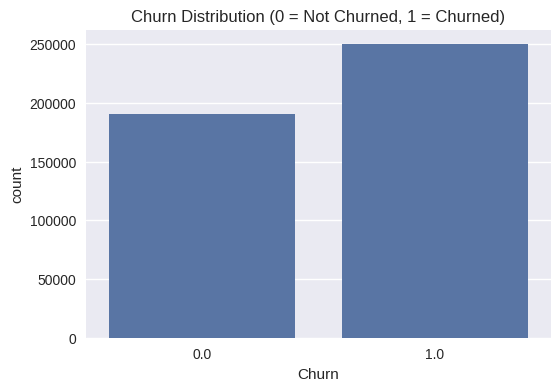


--- Churn Ratio ---
Churn
1.0    0.567107
0.0    0.432893
Name: proportion, dtype: float64

✅ Categorical encoding completed.
✅ Feature engineering completed.

✅ Final Feature Shapes — Train: (440832, 13), Test: (64374, 13)
✅ Scaling completed.

--- Comparing Models (5-Fold CV, AUC) ---

➡️ Training RandomForest...
RandomForest    → Mean AUC: 1.0000 ± 0.0000
✅ Saved RandomForest to models/RandomForest.pkl

➡️ Training XGBoost...


/home/parasuram/anaconda3/envs/workv1/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:15:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/parasuram/anaconda3/envs/workv1/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:15:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/parasuram/anaconda3/envs/workv1/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:15:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/parasuram/anaconda3/envs/workv1/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:15:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/parasuram/anaconda3/envs/workv1/lib/python

XGBoost         → Mean AUC: 1.0000 ± 0.0000
✅ Saved XGBoost to models/XGBoost.pkl

🏆 Best Model: RandomForest

✅ All models and preprocessors saved successfully in 'models/' folder!


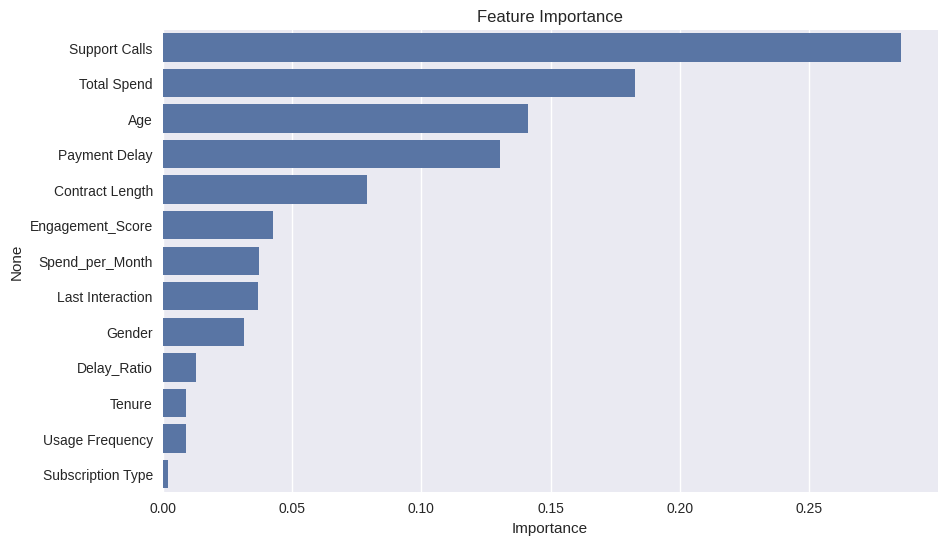


--- Top 5 Important Features ---
Support Calls      0.285229
Total Spend        0.182404
Age                0.141379
Payment Delay      0.130438
Contract Length    0.078864
dtype: float64

✅ Submission saved with 64374 predictions.

--- Optional: Validation Metrics (Holdout 20%) ---
AUC:        1.0000
F1-Score:   0.9996
Precision:  0.9999
Recall:     0.9993

--- Classification Report ---
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     38167
         1.0       1.00      1.00      1.00     50000

    accuracy                           1.00     88167
   macro avg       1.00      1.00      1.00     88167
weighted avg       1.00      1.00      1.00     88167



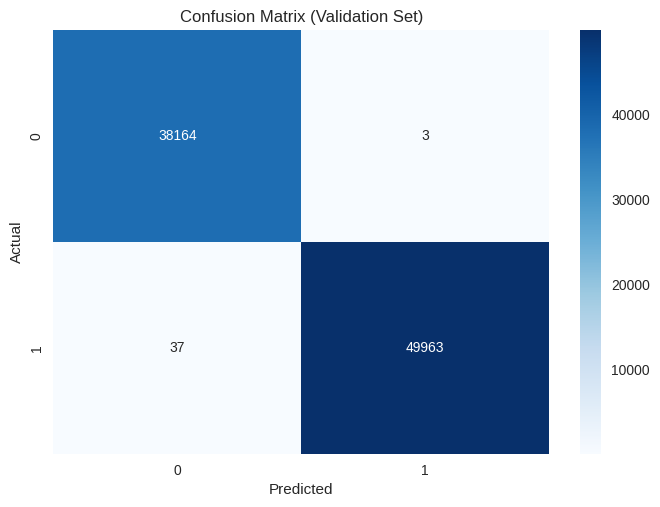


🎉 CHURN PREDICTION PIPELINE COMPLETED SUCCESSFULLY!


In [32]:
# ================================
# CUSTOMER CHURN PREDICTION
# ================================

# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')

# ================================
# STEP 1: LOAD DATA
# ================================
train_df = pd.read_csv('/home/parasuram/Tango/EDGE/archive/customer_churn_dataset-training-master.csv')
test_df = pd.read_csv('/home/parasuram/Tango/EDGE/archive/customer_churn_dataset-testing-master.csv')

print("✅ Train Shape:", train_df.shape)
print("✅ Test Shape:", test_df.shape)

# Display sample
print("\n--- Sample Train Data ---")
print(train_df.head(3))

# ================================
# STEP 2: BASIC DATA INSPECTION
# ================================
print("\n--- Train Info ---")
print(train_df.info())

print("\n--- Missing Values (Train) ---")
print(train_df.isnull().sum())

print("\n--- Missing Values (Test) ---")
print(test_df.isnull().sum())

# Drop rows with missing values (optional: you can impute instead)
train_df = train_df.dropna()
test_df = test_df.dropna()

print(f"\n✅ After dropping NA: Train = {train_df.shape}, Test = {test_df.shape}")

# ================================
# STEP 3: EDA — TARGET DISTRIBUTION
# ================================
plt.figure(figsize=(6,4))
sns.countplot(data=train_df, x='Churn')
plt.title('Churn Distribution (0 = Not Churned, 1 = Churned)')
plt.show()

churn_ratio = train_df['Churn'].value_counts(normalize=True)
print("\n--- Churn Ratio ---")
print(churn_ratio)

# ================================
# STEP 4: ENCODE CATEGORICAL VARIABLES
# ================================
categorical_cols = ['Gender', 'Subscription Type', 'Contract Length']

# Initialize label encoders (store them for reuse on test set)
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    label_encoders[col] = le  # Save encoder for test set

# Apply same encoding to test set
for col in categorical_cols:
    le = label_encoders[col]
    # Handle unseen labels in test set
    test_df[col] = test_df[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)

print("\n✅ Categorical encoding completed.")

# ================================
# STEP 5: FEATURE ENGINEERING (OPTIONAL)
# ================================
# Create new features that might help
train_df['Engagement_Score'] = train_df['Usage Frequency'] / (train_df['Support Calls'] + 1)
train_df['Delay_Ratio'] = train_df['Payment Delay'] / train_df['Tenure'].clip(lower=1)
train_df['Spend_per_Month'] = train_df['Total Spend'] / train_df['Tenure'].clip(lower=1)

test_df['Engagement_Score'] = test_df['Usage Frequency'] / (test_df['Support Calls'] + 1)
test_df['Delay_Ratio'] = test_df['Payment Delay'] / test_df['Tenure'].clip(lower=1)
test_df['Spend_per_Month'] = test_df['Total Spend'] / test_df['Tenure'].clip(lower=1)

print("✅ Feature engineering completed.")

# ================================
# STEP 6: PREPARE FEATURES & TARGET
# ================================
# Drop ID and Churn from features
X = train_df.drop(['CustomerID', 'Churn'], axis=1)
y = train_df['Churn']

# For test set — drop Churn if exists, else just drop ID
if 'Churn' in test_df.columns:
    X_test_raw = test_df.drop(['CustomerID', 'Churn'], axis=1)
else:
    X_test_raw = test_df.drop(['CustomerID'], axis=1)

# ⚠️ CRITICAL: Align column order with training set
X_test_raw = X_test_raw[X.columns]  # Ensure same columns and order

print(f"\n✅ Final Feature Shapes — Train: {X.shape}, Test: {X_test_raw.shape}")

# ================================
# STEP 7: FEATURE SCALING
# ================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Transform test set
X_test_scaled = scaler.transform(X_test_raw)
X_test = pd.DataFrame(X_test_scaled, columns=X_test_raw.columns)

print("✅ Scaling completed.")

# # ================================
# # STEP 8: MODEL COMPARISON
# # ================================
# print("\n--- Comparing Models (5-Fold CV, AUC) ---")

# models = {
#     "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1),
#     "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
# }

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# results = {}

# for name, model in models.items():
#     scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
#     results[name] = scores
#     print(f"{name:15} → Mean AUC: {scores.mean():.4f} ± {scores.std()*2:.4f}")

# # Select best model (XGBoost usually wins)
# best_model_name = max(results, key=lambda k: results[k].mean())
# print(f"\n🏆 Best Model: {best_model_name}")

# # ================================
# # STEP 9: TRAIN FINAL MODEL
# # ================================
# # ================================
# # STEP 9: TRAIN FINAL MODEL
# # ================================
# final_model = models[best_model_name]
# final_model.fit(X, y)

# print("✅ Final model trained.")

# # ================================
# # 🧠 STEP 9.5: SAVE MODEL & PREPROCESSORS 👈 INSERT THIS BLOCK
# # ================================
# import pickle

# with open('churn_model.pkl', 'wb') as f:
#     pickle.dump(final_model, f)

# with open('scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)

# with open('label_encoders.pkl', 'wb') as f:
#     pickle.dump(label_encoders, f)

# with open('feature_columns.pkl', 'wb') as f:
#     pickle.dump(X.columns.tolist(), f)

# print("✅ Model, scaler, encoders, and feature columns saved to disk!")

# ================================
# STEP 8: MODEL COMPARISON & TRAINING ALL MODELS
# ================================
print("\n--- Comparing Models (5-Fold CV, AUC) ---")

models = {
    "RandomForest": RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
    # Add more models here if you want
    # "LogisticRegression": LogisticRegression(random_state=42, max_iter=1000),
    # "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

# Create 'models' folder if it doesn't exist
import os
os.makedirs('models', exist_ok=True)

# Train and save each model
for name, model in models.items():
    print(f"\n➡️ Training {name}...")
    model.fit(X, y)
    
    # Cross-validate
    scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
    results[name] = scores
    print(f"{name:15} → Mean AUC: {scores.mean():.4f} ± {scores.std()*2:.4f}")
    
    # Save model to models/ folder
    model_path = f"models/{name}.pkl"
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    print(f"✅ Saved {name} to {model_path}")

# Select best model (for your pipeline/test predictions)
best_model_name = max(results, key=lambda k: results[k].mean())
final_model = models[best_model_name]
print(f"\n🏆 Best Model: {best_model_name}")

# ================================
# 🧠 STEP 9.5: SAVE SHARED PREPROCESSORS TO models/ FOLDER
# ================================
import pickle

# Save scaler
with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save label encoders
with open('models/label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

# Save feature column order (CRITICAL for future predictions)
with open('models/feature_columns.pkl', 'wb') as f:
    pickle.dump(X.columns.tolist(), f)

print("\n✅ All models and preprocessors saved successfully in 'models/' folder!")
# ================================
# STEP 10: FEATURE IMPORTANCE
# ================================
if hasattr(final_model, 'feature_importances_'):
    importances = final_model.feature_importances_
    feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

    plt.figure(figsize=(10,6))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.show()

    print("\n--- Top 5 Important Features ---")
    print(feat_imp.head())

# ================================
# STEP 11: PREDICT ON TEST SET
# ================================
test_pred_proba = final_model.predict_proba(X_test)[:, 1]  # Probability of churn
test_pred = final_model.predict(X_test)

# ================================
# STEP 12: CREATE SUBMISSION FILE
# ================================
submission = pd.DataFrame({
    'CustomerID': test_df['CustomerID'],
    'Churn_Probability': test_pred_proba,
    'Churn_Prediction': test_pred.astype(int)
})

# Save to CSV
submission.to_csv('churn_predictions.csv', index=False)
print(f"\n✅ Submission saved with {len(submission)} predictions.")

# ================================
# STEP 13: OPTIONAL — VALIDATION METRICS (If you hold out validation set)
# ================================
print("\n--- Optional: Validation Metrics (Holdout 20%) ---")
X_train_hold, X_val, y_train_hold, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

final_model.fit(X_train_hold, y_train_hold)
y_val_pred = final_model.predict(X_val)
y_val_proba = final_model.predict_proba(X_val)[:,1]

print(f"AUC:        {roc_auc_score(y_val, y_val_proba):.4f}")
print(f"F1-Score:   {f1_score(y_val, y_val_pred):.4f}")
print(f"Precision:  {precision_score(y_val, y_val_pred):.4f}")
print(f"Recall:     {recall_score(y_val, y_val_pred):.4f}")

print("\n--- Classification Report ---")
print(classification_report(y_val, y_val_pred))

# Plot confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Validation Set)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ================================
# 🎉 DONE!
# ================================
print("\n🎉 CHURN PREDICTION PIPELINE COMPLETED SUCCESSFULLY!")